Importation des modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

Importation des doonées

In [ ]:
data = pd.read_excel('/content/Utrecht.xlsx')

data.head()

,Time,Hour of the year,Normalized PV power corrected,PV power (kW),temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),wind_speed_10m (km/h),cloud_cover (%),global_tilted_irradiance (W/m²)
0,2014-01-01 00:00:00,1,0.0,0.0,5.8,90,1.4,20.5,100,0.0
1,2014-01-01 01:00:00,2,0.0,0.0,6.0,92,1.8,20.0,99,0.0
2,2014-01-01 02:00:00,3,0.0,0.0,6.2,93,2.3,18.9,91,0.0
3,2014-01-01 03:00:00,4,0.0,0.0,6.3,93,2.5,18.0,43,0.0
4,2014-01-01 04:00:00,5,0.0,0.0,5.8,93,1.9,18.6,11,0.0


Modèle linéaire régularisée


https://datascientest.com/regression-lineaire-python#:~:text=Le%20mod%C3%A8le%20de%20r%C3%A9gression%20lin%C3%A9aire,(variables%20ind%C3%A9pendantes%20ou%20pr%C3%A9dictives).

https://ithy.com/article/evaluation-metrices-regression-mae-mse-rmse-r2-jqlx1zyp

# 📊 Indicateurs de Performance

Voici les définitions des métriques utilisées pour évaluer le modèle, où $y$ est la valeur réelle et $\hat{y}$ la valeur prédite.

### 1. MAE (Mean Absolute Error)
L'**Erreur Absolue Moyenne** mesure la moyenne des écarts absolus. Elle est facile à interpréter car elle est dans la même unité que la production (kW/kWc).

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$$

---

### 2. RMSE (Root Mean Squared Error)
La **Racine de l'Erreur Quadratique Moyenne**. Elle pénalise davantage les grandes erreurs que le MAE. C'est souvent ce que le modèle cherche à minimiser mathématiquement.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2}$$

---

### 3. MAPE (Mean Absolute Percentage Error)
L'**Erreur Moyenne Absolue en Pourcentage**. Elle exprime l'erreur en % par rapport à la réalité.
*(Attention : peut être biaisée si la production réelle est proche de 0)*.

$$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_{i} - \hat{y}_{i}}{y_{i}} \right|$$

---

### 4. $R^2$ (Coefficient de détermination)
Il mesure la qualité de la prédiction par rapport à une simple moyenne.
* $R^2 = 1$ : Prédiction parfaite.
* $R^2 = 0$ : Le modèle prédit juste la moyenne constante.

$$R^2 = 1 - \frac{\sum (y_{i} - \hat{y}_{i})^2}{\sum (y_{i} - \bar{y})^2}$$

Le MAPE (Mean Absolute Percentage Error) semble inadapté dans notre cas notamment à cause des intermittences jour/nuit. Lorsque la prod atteint des chiffres très bas, alors cet indicateur devient très grand. Etant donné que notre modèle est basé sur la production normalisée, les résultats affichent des MAPE très élevé

Un point d’attention : la relation physique entre irradiance, température et production n’est pas strictement additive. Intégrer des interactions (par exemple via **PolynomialFeatures** ou une variable Irradiance * Temperature) renforcerait probablement les performances du modèle tout en restant interprétable.

Ici on compare donc les polynômes d'ordre 1 et 2 et on choisit le meilleur en se basant sur le MAE

In [6]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib

# 1. Préparation des données
data_clean = data.copy()
if not isinstance(data_clean.index, pd.DatetimeIndex):
    data_clean.index = pd.to_datetime(data_clean['Time'])

data_clean['hour'] = data_clean.index.hour
data_clean['month'] = data_clean.index.month
data_clean['day_of_year'] = data_clean.index.dayofyear
data_clean['year'] = data_clean.index.year

variables = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'global_tilted_irradiance (W/m²)',
             'wind_speed_10m (km/h)', 'cloud_cover (%)', 'hour', 'month', 'day_of_year']
target = 'Normalized PV power corrected'

# Séparation temporelle stricte
X_train, y_train = data_clean[data_clean['year'].isin([2014, 2015])][variables], data_clean[data_clean['year'].isin([2014, 2015])][target]
X_val, y_val     = data_clean[data_clean['year'] == 2016][variables], data_clean[data_clean['year'] == 2016][target]
X_test, y_test   = data_clean[data_clean['year'] == 2017][variables], data_clean[data_clean['year'] == 2017][target]

# 2. Création et Entraînement du modèle Ridge
# Le StandardScaler est indispensable car Ridge pénalise la norme des coefficients
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0)
)

model.fit(X_train, y_train)

# 3. Évaluation sur l'année de VALIDATION (2016)
y_val_pred = np.clip(model.predict(X_val), 0, 1)
mae_val = mean_absolute_error(y_val, y_val_pred)
print(f"MAE Validation (2016) : {mae_val:.4f}")


# 4. Évaluation finale sur l'année de TEST (2017)
y_test_pred = np.clip(model.predict(X_test), 0, 1)
# Calcul du SMAPE corrigé
smape = 100 * np.mean(2 * np.abs(y_test_pred - y_test) / (np.abs(y_test) + np.abs(y_test_pred) + 1e-9))

print("-" * 30)
print(f"RÉSULTATS FINAUX TEST 2017 :")
print(f"R²   : {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"SMAPE : {smape:.2f}%")
print("-" * 30)

# 5. Extraction des coefficients
poly = model.named_steps['polynomialfeatures']
regressor = model.named_steps['ridge']

feature_names = poly.get_feature_names_out(variables)
coefficients = regressor.coef_

print(f"\nIntercept : {regressor.intercept_:.6f}")
coef_df = pd.DataFrame({'Variable': feature_names, 'Coefficient': coefficients})
print(coef_df.to_string())

# 6. Sauvegarde
joblib.dump(model, 'modele_ridge_solaire.pkl')
print(f"\nModèle sauvegardé sous 'modele_ridge_solaire.pkl'")

MAE Validation (2016) : 0.0557
------------------------------
RÉSULTATS FINAUX TEST 2017 :
R²   : 0.7708
MAE  : 0.0512
RMSE : 0.0902
SMAPE : 79.87%
------------------------------

Intercept : 0.113529
                                                    Variable  Coefficient
0                                        temperature_2m (°C)    -0.033030
1                                   relative_humidity_2m (%)    -0.034656
2                            global_tilted_irradiance (W/m²)     0.607596
3                                      wind_speed_10m (km/h)     0.023055
4                                            cloud_cover (%)    -0.020618
5                                                       hour    -0.046537
6                                                      month     0.000367
7                                                day_of_year    -0.101878
8                                      temperature_2m (°C)^2    -0.002166
9               temperature_2m (°C) relative_humidity_2m (%

NameError: name 'y_pred_test' is not defined

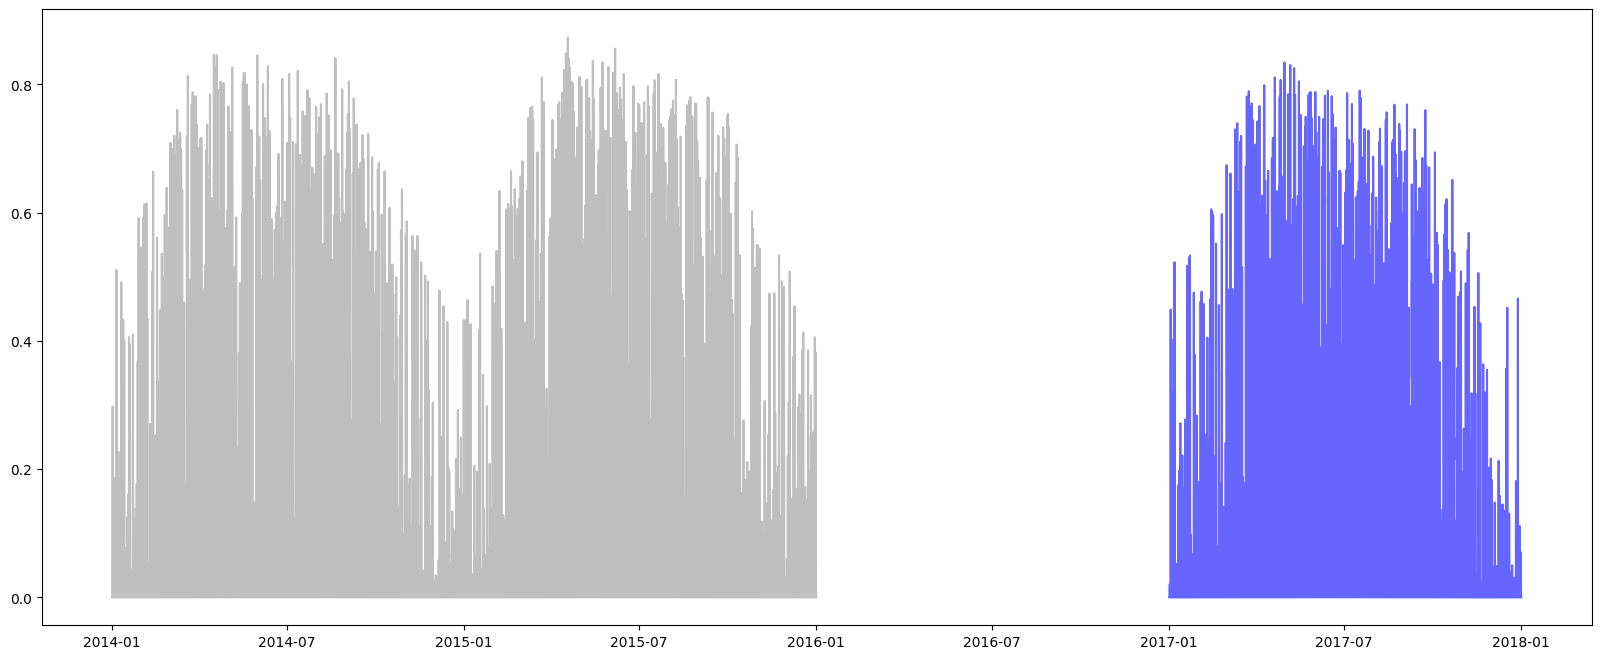

In [5]:
plt.figure(figsize=(20, 8))

# On trace la partie Entraînement (Le passé)
plt.plot(y_train.index, y_train, label='Données Entraînement', color='gray', alpha=0.5)

# On trace la partie Réalité du Test (Le futur réel)
plt.plot(y_test.index, y_test, label='Réalité (Test)', color='blue', alpha=0.6)

# On trace votre Prédiction (Le futur calculé)
plt.plot(y_test.index, y_pred_test, label='Prédiction (Modèle)', color='red', linestyle='--')

plt.axvline(x=y_train.index[-1], color='black', linestyle='-', label='Séparation Train/Test') # Barre verticale

plt.xlabel('Temps')
plt.ylabel('Production normalisée (kW/kWc)')
plt.title('Production PV et prédiction à partir du modèle polynomiale ordre 2')
plt.legend()
plt.show()